In [5]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## The following analysis is for the CASA0006 final assignment

In this code we explore the following question: *Can unsupervised clustering reveal distinct patterns of household energy consumption across different regions of the UK, and what factors contribute to these patterns?*

The purpose of this analysis is to conduct an exploratory segmentation analysis of British energy consumption behaviour

### 0. Load Data & Inspect

In [83]:
# load cleaned & normalised data
gdf = gpd.read_file('normalised_energyconsumption_df.gpkg')

# check
gdf.head()

,Local authority districts,population,Name,gas_median_cons_kwh,elec_median_cons_kwh,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),mean annual income,geometry
0,E06000001,93861.0,Hartlepool,9603.810817,2252.975000,0.001225,0.050340,0.086149,0.154878,0.143499,0.003644,0.390855,0.001918,0.039654,33741.666667,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,148285.0,Middlesbrough,11800.598665,2810.900000,0.000344,0.051044,0.070061,0.171865,0.113080,0.005071,0.361790,0.001200,0.038332,35531.578947,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,E06000003,137175.0,Redcar and Cleveland,9716.993667,2271.833333,0.000612,0.040066,0.090753,0.203696,0.114204,0.004148,0.403251,0.002260,0.039679,35515.789474,"POLYGON ((455525.931 528406.654, 455724.632 52..."
3,E06000004,199966.0,Stockton-on-Tees,9882.238146,2398.133333,0.000395,0.038392,0.111064,0.177500,0.091506,0.003526,0.376619,0.001975,0.036736,38929.166667,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,E06000005,109469.0,Darlington,10613.598673,2298.300000,0.000713,0.058683,0.085239,0.174917,0.127315,0.004257,0.404863,0.002074,0.035681,39380.000000,"POLYGON ((423496.602 524724.299, 423497.204 52..."


In [85]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   Local authority districts           374 non-null    object  
 1   population                          357 non-null    float64 
 2   Name                                357 non-null    object  
 3   gas_median_cons_kwh                 345 non-null    float64 
 4   elec_median_cons_kwh                345 non-null    float64 
 5   dwelling_type: mobile               314 non-null    float64 
 6   dwelling_type: flat                 314 non-null    float64 
 7   dwelling_type: detached house       314 non-null    float64 
 8   dwelling_type: semi-detached        314 non-null    float64 
 9   dwelling_type: terraced             314 non-null    float64 
 10  no central heating                  314 non-null    float64 
 11  1 central heating       

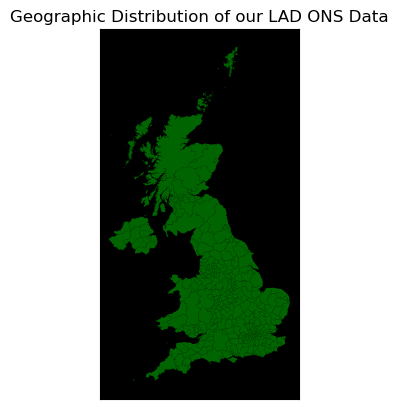

In [89]:
# plot data
# aesthetics
ax = gdf.plot(color='darkgreen', markersize=1)

# background, remove axis labels & title
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Geographic Distribution of our LAD ONS Data')

# plot
plt.show()

There is little data from Scotland as seen from this plot of 2041 data points. This means that this study will likely be unrepresentative of Scottish energy consumtion profiles

Before diving into the analysis, I need to remove outliers from the data set to ensure my scaling is correct for the EDA in the following section.

### 1. Summary Statistics

In [93]:
# descriptive statistics
gdf.describe()

,population,gas_median_cons_kwh,elec_median_cons_kwh,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),mean annual income
count,3.570000e+02,345.000000,345.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,317.000000
mean,1.845739e+05,10000.940142,2599.394588,0.002067,0.082017,0.108347,0.130504,0.092400,0.005939,0.371254,0.002470,0.035671,46829.911803
std,1.239675e+05,1279.731673,234.158592,0.002098,0.065401,0.055624,0.037655,0.034206,0.004523,0.023074,0.001553,0.006680,9496.311602
min,2.281000e+03,6159.518029,2030.400000,0.000000,0.017910,0.000645,0.001383,0.007191,0.002067,0.259097,0.000777,0.023665,32926.086957
25%,1.069700e+05,9303.130236,2442.288889,0.000503,0.044090,0.061627,0.113079,0.070083,0.004013,0.359787,0.001545,0.031555,39575.438596
50%,1.456730e+05,9903.748734,2570.733333,0.001333,0.063788,0.108352,0.129826,0.087103,0.004991,0.372924,0.002032,0.034285,44745.454545
75%,2.269730e+05,10535.170836,2727.285714,0.002957,0.094242,0.154927,0.153265,0.107266,0.006824,0.388052,0.003090,0.038071,52148.484848
max,1.157603e+06,18285.958163,3940.500000,0.013217,0.443809,0.230133,0.208866,0.226177,0.072337,0.420104,0.017536,0.064007,101800.000000


### 2. *Gas* Exploratory Data Analysis (EDA)

**In this section we conduct several crucial steps for our analysis.** 

**This includes a:**

- Exploratory Data Analysis (EDA)
- Normalisation of our data in order to standardise our results
- Detect outliars in out data.
- Split our data into training and testing data

#### 2.1 Univariate Analysis

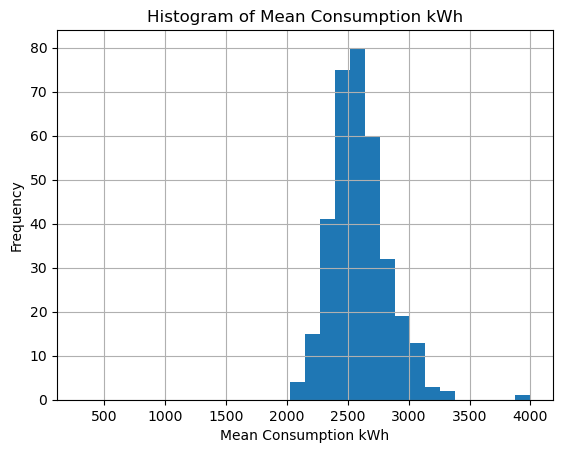

In [109]:
# histogram for 'medina_cons_kwh'
gdf['elec_median_cons_kwh'].hist(bins=30, range=(300, 4000))
plt.title('Histogram of Mean Consumption kWh')
plt.xlabel('Mean Consumption kWh')
plt.ylabel('Frequency')
plt.show()

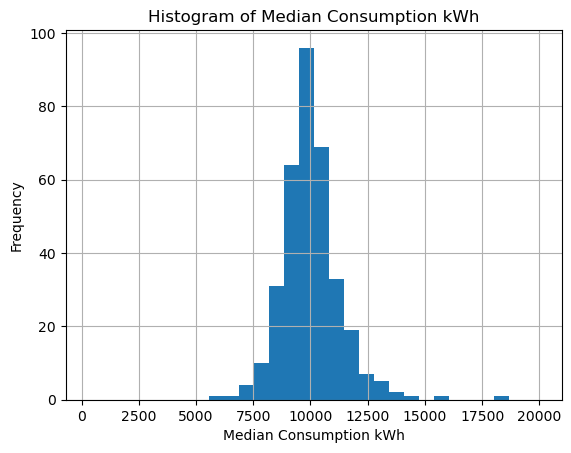

In [111]:
# histogram for 'median_cons_kwh'
gdf['gas_median_cons_kwh'].hist(bins=30, range=(300, 20000))
plt.title('Histogram of Median Consumption kWh')
plt.xlabel('Median Consumption kWh')
plt.ylabel('Frequency')
plt.show()

#### 2.2 Multivariate Analysis

In [ ]:
# correlation matrix
correlation_matrix = gdf[['ngas_total_cons_kwh', 'ngas_mean_cons_kwh', 'ngas_median_cons_kwh', 'nelec_total_cons_kwh', 'nelec_mean_cons_kwh', 'nelec_median_cons_kwh']].corr()

# heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [ ]:
if not isinstance(gdf, gpd.GeoDataFrame):
    gdf = gpd.GeoDataFrame(gdf)

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='ngas_mean_cons_kwh', ax=ax, legend=True, cmap='viridis')
plt.title('Geospatial Distribution of Mean Gas Consumption')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
if not isinstance(gdf, gpd.GeoDataFrame):
    gdf = gpd.GeoDataFrame(gdf)

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='nelec_mean_cons_kwh', ax=ax, legend=True, cmap='viridis')
plt.title('Geospatial Distribution of Mean Electricity Consumption')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### 2.3 Anomaly Detection

In [ ]:
# convert columns to numeric type, coercing errors to NaN
gdf['nelec_total_cons_kwh'] = pd.to_numeric(gdf['nelec_total_cons_kwh'], errors='coerce')
gdf['nelec_mean_cons_kwh'] = pd.to_numeric(gdf['nelec_mean_cons_kwh'], errors='coerce')
gdf['nelec_median_cons_kwh'] = pd.to_numeric(gdf['nelec_median_cons_kwh'], errors='coerce')

# calculate quartiles after type conversion
Q1 = gdf[['nelec_total_cons_kwh', 'nelec_mean_cons_kwh', 'nelec_median_cons_kwh']].quantile(0.25)
Q3 = gdf[['nelec_total_cons_kwh', 'nelec_mean_cons_kwh', 'nelec_median_cons_kwh']].quantile(0.75)
IQR = Q3 - Q1

# IQR to define outliars
outliers = (gdf[['nelec_total_cons_kwh', 'nelec_mean_cons_kwh', 'nelec_median_cons_kwh']] < (Q1 - 1.5 * IQR)) | (gdf[['nelec_total_cons_kwh', 'nelec_mean_cons_kwh', 'nelec_median_cons_kwh']] > (Q3 + 1.5 * IQR))

# print outliers
outliers.sum()

#### 2.4 Normalise tot_con_kwh

In [ ]:
# creating new feature: log transformation of 'total_cons_kwh' to normalise distribution
gdf['log_total_cons_kwh'] = np.log(gdf['ngas_total_cons_kwh'] + 1)
gdf['log_total_cons_kwh'].hist(bins=30)
plt.title('Histogram of Log-transformed Total Consumption kWh')
plt.xlabel('Log-transformed Total Consumption kWh')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# creating new feature: log transformation of 'total_cons_kwh' to normalise distribution
gdf['log_total_cons_kwh'] = np.log(gdf['nelec_total_cons_kwh'] + 1)
gdf['log_total_cons_kwh'].hist(bins=30)
plt.title('Histogram of Log-transformed Total Consumption kWh')
plt.xlabel('Log-transformed Total Consumption kWh')
plt.ylabel('Frequency')
plt.show()

#### 2.5 Split gdf in training and testing data

In [ ]:
from sklearn.model_selection import train_test_split

# split into training & test sets
train_set, test_set = train_test_split(gdf, test_size=0.2, random_state=42)
print("Training set size:", train_set.shape)
print("Test set size:", test_set.shape)

### 3. K-Means Clustering

### 4. Hierarchal Clustering